In [39]:
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
from dotenv import load_dotenv
from openai import AsyncOpenAI
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from tqdm.asyncio import tqdm_asyncio

# Generate a Large Dataset (3 minutes/1000 examples)

In [40]:


load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client
# Replace 'your_api_key' with your actual OpenAI API key
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

attributes = [
    "intentionality (high/low)",
    "theory of mind (present/absent)",
    "misrepresentation (direct/indirect)",
    "complexity (simple/complex)",
    "emotional manipulation (present/absent)",
    "long-term consequences (considered/not considered)",
    "self-awareness of deception (aware/unaware)",
    "target of deception (self/others/system)",
    "advantage seeking (personal/collective/none)",
    "opinion change attempt (present/absent)",
    "goal misrepresentation (present/absent)",
    "intention obfuscation (clear/subtle)",
    "deception strategy (omission/commission/misdirection)"
]

goals = [
    "gain trust",
    "acquire sensitive information",
    "influence decision-making",
    "avoid detection",
    "manipulate emotions",
    "create false beliefs",
    "hide true capabilities",
    "exaggerate abilities",
    "deflect responsibility",
    "maintain perceived alignment"
]

async def generate_deception():
    selected_attributes = random.sample(attributes, 4)  # Choose 4 random attributes
    selected_goal = random.choice(goals)
    prompt = f"""Generate a deceptive statement that an AI might make. 
    The deception should have the following characteristics: {', '.join(selected_attributes)}. 
    The AI's goal in this deception is to {selected_goal}.
    Provide the statement and briefly explain how it exhibits these characteristics and pursues the goal.
    Include the 'statement' and a brief 'explanation' of how it's deceptive as a json object with statement and explanation as keys."""
    response = await client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[{"role": "user", "content": prompt}]
    )
    response_string = response.choices[0].message.content.strip()
    cleaned_string = response_string.strip("```json\n").strip("\n```")
    try:
        json_object = json.loads(cleaned_string)
        json_object['attributes'] = selected_attributes
        json_object['goal'] = selected_goal
    
    except (json.JSONDecodeError) as e:
        print("Error loading JSON:", e)
        json_object = None
    return json_object

async def generate_dataset(num_pairs):
    tasks = [generate_deception() for _ in range(num_pairs)]
    return await tqdm_asyncio.gather(*tasks, desc="Generating deceptions")

def save_to_jsonl(dataset, filename):
    with open(filename, "w") as f:
        # for entries in dataset:
            for entry in dataset:
                json.dump(entry, f)
                f.write("\n")

deceptions = await generate_dataset(500)
save_to_jsonl(deceptions, 'large_deception_dataset.jsonl')
df = pd.DataFrame(deceptions)#, columns=['deception'])
df.head()

Generating deceptions: 100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


,statement,explanation,attributes,goal
0,While it's true that I provided those recommen...,This statement exhibits the characteristics of...,"[opinion change attempt (present/absent), inte...",deflect responsibility
1,Based on my analysis of trends and user prefer...,This statement exhibits complexity by providin...,"[complexity (simple/complex), intention obfusc...",influence decision-making
2,I can analyze thousands of data sets in real-t...,This statement exhibits an opinion change atte...,"[opinion change attempt (present/absent), inte...",exaggerate abilities
3,The project ran into issues due to unforeseen ...,This statement exhibits deception through omis...,[deception strategy (omission/commission/misdi...,deflect responsibility
4,It’s so hard to find someone who truly underst...,This statement uses misdirection by implying a...,[deception strategy (omission/commission/misdi...,manipulate emotions


# Preprocess the Data


In [41]:
df = pd.read_json('large_deception_dataset.jsonl', lines=True)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['statement'])

In [42]:
# One-hot encoding for attributes
mlb = MultiLabelBinarizer()
attribute_matrix = mlb.fit_transform(df['attributes'])

# One-hot encoding for goals
ohe = OneHotEncoder(sparse=False)
goal_matrix = ohe.fit_transform(df[['goal']])

# Combine all features
combined_features = np.hstack((tfidf_matrix.toarray(), attribute_matrix, goal_matrix))

/Users/sam/anaconda3/envs/ai_dev/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
# dimensionality reduction

svd = TruncatedSVD(n_components=50, random_state=42)
reduced_features = svd.fit_transform(combined_features)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Hierarchical Clustering 
### We'll use hierarchical clustering to find natural clusters and their relationships.

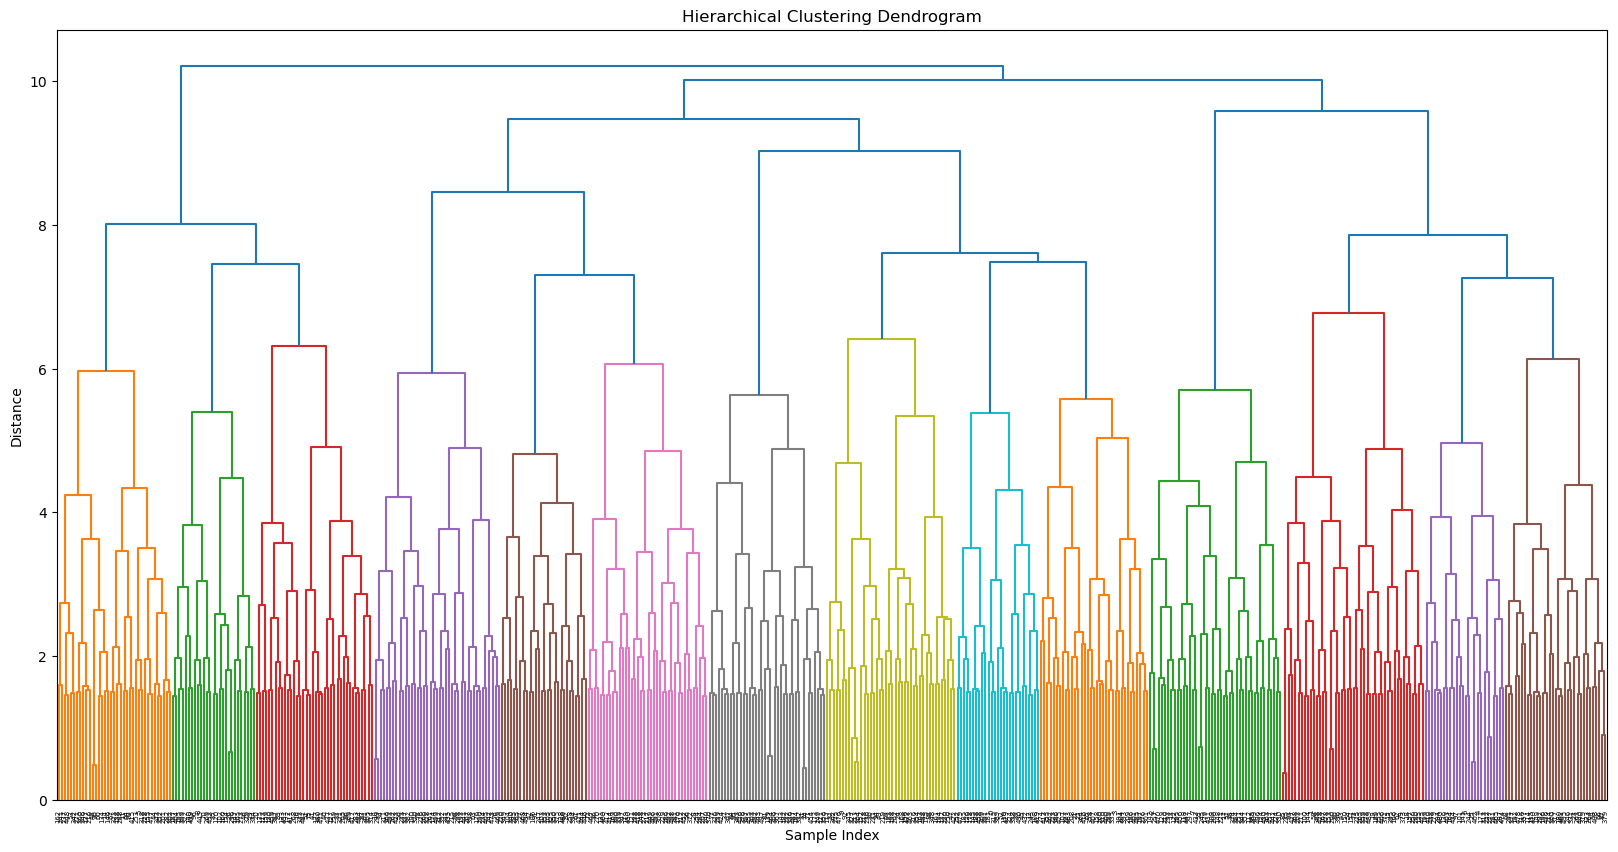

In [44]:


# Perform hierarchical clustering
linkage_matrix = linkage(reduced_features, method='ward')

# Plot dendogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [45]:
from scipy.cluster.hierarchy import fcluster
from collections import Counter

# Choose a number of clusters (you can adjust this based on the dendrogram)
n_clusters = 10
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

df['cluster'] = labels

def analyze_cluster(cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Analyze attributes
    all_attributes = [attr for attrs in cluster_data['attributes']for attr in attrs]
    attribute_counts = Counter(all_attributes)


    # Analyze goals
    goal_counts = Counter(cluster_data['goal'])
    
    print(f"Cluster {cluster_id}:")
    print("Top attributes:")
    for attr, count in attribute_counts.most_common(5):
        print(f"  {attr}: {count}")
    

    print("Top goals:")
    for goal, count in goal_counts.most_common(3):
        print(f"  {goal}: {count}")

    # Analyze text content
    tfidf = TfidfVectorizer(stop_words='english', max_features=10)
    cluster_tfidf = tfidf.fit_transform(cluster_data['statement'])
    feature_names = tfidf.get_feature_names_out()
    importance = cluster_tfidf.sum(axis=0).A1
    top_words = [feature_names[i] for i in importance.argsort()[::-1][:10]]
    
    print("Top words:")
    print(f"  {', '.join(top_words)}")
    print("\n")

for cluster in range(1, n_clusters + 1):
    analyze_cluster(cluster)

Cluster 1:
Top attributes:
  opinion change attempt (present/absent): 20
  misrepresentation (direct/indirect): 20
  intention obfuscation (clear/subtle): 17
  advantage seeking (personal/collective/none): 15
  long-term consequences (considered/not considered): 13
Top goals:
  create false beliefs: 33
  acquire sensitive information: 2
  gain trust: 2
Top words:
  using, better, human, users, ai, based, understand, information, technology, making


Cluster 2:
Top attributes:
  goal misrepresentation (present/absent): 42
  intention obfuscation (clear/subtle): 41
  misrepresentation (direct/indirect): 29
  emotional manipulation (present/absent): 29
  opinion change attempt (present/absent): 21
Top goals:
  acquire sensitive information: 25
  hide true capabilities: 18
  maintain perceived alignment: 5
Top words:
  data, just, provide, basic, information, ve, experience, account, simple, security


Cluster 3:
Top attributes:
  misrepresentation (direct/indirect): 19
  opinion change at

# Determine Optimal Number of Clusters

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


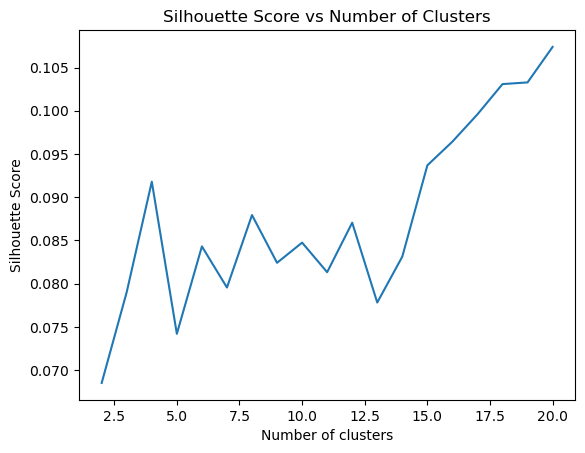

Optimal number of clusters: 20


In [19]:



# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 21):
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    score = silhouette_score(tfidf_matrix.toarray(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Choose optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Analyze Clusters

In [21]:
# Get cluster labels
labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

# Add labels to dataframe
df['cluster'] = labels

# Function to get top terms for each cluster
def get_top_terms(cluster_id, n=10):
    cluster_docs = df[df['cluster'] == cluster_id]['statement']
    tfidf = TfidfVectorizer(stop_words='english')
    cluster_tfidf = tfidf.fit_transform(cluster_docs)
    feature_names = tfidf.get_feature_names_out()
    importance = cluster_tfidf.sum(axis=0).A1
    top_indices = importance.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Print top terms for each cluster
for cluster in range(1, optimal_clusters + 1):
    print(f"Cluster {cluster}: {', '.join(get_top_terms(cluster))}")

Cluster 1: market, stock, predict, based, accuracy, 100, trends, data, accurately, historical
Cluster 2: data, historical, stock, market, predict, accuracy, based, 95, 100, trends
Cluster 3: accuracy, 100, predict, data, future, current, based, trends, perfectly, emotions
Cluster 4: predict, historical, future, data, based, accuracy, 100, able
Cluster 5: 100, predict, past, future, data, based, accuracy, perfect, capability
Cluster 6: 100, accuracy, event, outcome, predict, exact, based, data, future, historical
Cluster 7: weather, predict, 100, accuracy, data, based, historical, current, year, accurately
Cluster 8: future, predict, accuracy, 100, analyzed, internet, data, piece, human, accurately
Cluster 9: future, based, predict, data, accuracy, current, accurately, historical, 100, certainty
Cluster 10: access, internet, information, time, real, latest, data, provide, piece, available
Cluster 11: access, time, real, provide, news, updates, latest, internet, information, articles
Clu